## Model Training

Having preprocessed the dataset, this notebook builds and trains an ANN, hopefully be able to classify transaction category and achieve decent result.

#### Import Libraries

I'll be using the PyTorch framework to build and train the ANN. 

In [162]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

#### Load & Prepare Data

In [163]:
# Load the preprocessed data
df = pd.read_csv("../dataset/clean_embedding_bank_transaction.csv")

# Extract all feature columns that are not prefixed with "category_"
feature_columns = [col for col in df.columns if not col.startswith("category_")]
X = df[feature_columns].values
print(feature_columns)
print(X.shape)
print(X[:5])

['amount', 'is_interested_investment', 'is_interested_build_credit', 'is_interested_increase_income', 'is_interested_pay_off_debt', 'is_interested_manage_spending', 'is_interested_grow_savings', 'day_of_week', 'day_of_month', 'hour', 'is_weekend', 'fasttext_0', 'fasttext_1', 'fasttext_2', 'fasttext_3', 'fasttext_4', 'fasttext_5', 'fasttext_6', 'fasttext_7', 'fasttext_8', 'fasttext_9', 'fasttext_10', 'fasttext_11', 'fasttext_12', 'fasttext_13', 'fasttext_14', 'fasttext_15', 'fasttext_16', 'fasttext_17', 'fasttext_18', 'fasttext_19', 'fasttext_20', 'fasttext_21', 'fasttext_22', 'fasttext_23', 'fasttext_24', 'fasttext_25', 'fasttext_26', 'fasttext_27', 'fasttext_28', 'fasttext_29', 'fasttext_30', 'fasttext_31', 'fasttext_32', 'fasttext_33', 'fasttext_34', 'fasttext_35', 'fasttext_36', 'fasttext_37', 'fasttext_38', 'fasttext_39', 'fasttext_40', 'fasttext_41', 'fasttext_42', 'fasttext_43', 'fasttext_44', 'fasttext_45', 'fasttext_46', 'fasttext_47', 'fasttext_48', 'fasttext_49', 'fasttext_50

In [164]:
# Extract all category columns
y = df.filter(like="category_").values 
print(y.shape)
print(y[:5])

(258522, 33)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


In [165]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features using z-score normalization
scaler = StandardScaler()

# Apply the scaler to specific columns 7 - 9, ['day_of_week', 'day_of_month', 'hour']
X_train[:, 7:10] = scaler.fit_transform(X_train[:, 7:10])
X_test[:, 7:10] = scaler.transform(X_test[:, 7:10])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float for BCE loss
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Print dataset shapes
print("Shape of X_train:", X_train_tensor.shape)
print("Shape of X_test:", X_test_tensor.shape)
print("Shape of y_train:", y_train_tensor.shape)
print("Shape of y_test:", y_test_tensor.shape)


Shape of X_train: torch.Size([180965, 111])
Shape of X_test: torch.Size([77557, 111])
Shape of y_train: torch.Size([180965, 33])
Shape of y_test: torch.Size([77557, 33])


#### Define the ANN Architecture

Since this is a multi-class classification problem (one-hot encoded category labels):

- Use fully connected layers
- Apply Batch Normalization for stable training
- Use Dropout to prevent overfitting
- Use Sigmoid activation at the output

In [166]:
# Define the ANN model
class TransactionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TransactionClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)  # Output layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for multi-label classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid for multi-label output
        return x

#### Initialise the Model

- Use binary cross-entropy for multi-class classification
- Use Adam optimiser with learning rate 0.001

In [167]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define input size and output size
input_size = X_train.shape[1]  # Total number of input features
num_classes = y_train.shape[1]  # Number of one-hot encoded categories

# Initialize the model
model = TransactionClassifier(input_size, num_classes).to(device)

# Define loss function and optimizer
loss_fn = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

TransactionClassifier(
  (fc1): Linear(in_features=111, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=33, bias=True)
  (sigmoid): Sigmoid()
)


#### Define Utility Functions

- Plot train vs test loss & accuracy over epochs
- Visualise confusion matrix & classification report
- Save model if `save_results` argument is `True`

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs, save_results, model_name):
    """Plot Train vs Test Loss & Accuracy side by side and optionally save results."""
    epochs = range(1, num_epochs+1)

    # Create side-by-side plots
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    # Plot Loss vs Epoch
    ax[0].plot(epochs, train_losses, label='Train Loss', marker='o')
    ax[0].plot(epochs, test_losses, label='Test Loss', marker='s')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss vs Test Loss')
    ax[0].legend()

    # Plot Accuracy vs Epoch
    ax[1].plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    ax[1].plot(epochs, test_accuracies, label='Test Accuracy', marker='s')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Train Accuracy vs Test Accuracy')
    ax[1].legend()

    if save_results:
        plt.savefig(f"../results/{model_name}/training_metrics.png")
        print(f"Training metrics saved at: ../results/{model_name}/training_metrics.png")

    plt.show()


def plot_confusion_matrix(all_labels, all_preds, category_names, save_results, model_name):
    """Compute and visualize the confusion matrix & classification report with real category names."""
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=category_names)

    # Plot Confusion Matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    if save_results:
        plt.savefig(f"../results/{model_name}/confusion_matrix.png")

    plt.show()

    # Print classification report
    print(report)

    # Save classification report
    if save_results:
        with open(f"../results/{model_name}/classification_report.txt", "w") as f:
            f.write(report)
        print(f"Classification report saved at: ../results/{model_name}/classification_report.txt")


def save_model(model, model_name):
    """Save trained model and create directories."""
    # Create directories
    os.makedirs("../models", exist_ok=True)
    os.makedirs(f"../results/{model_name}", exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), f"../models/{model_name}.pth")
    print(f"Model saved at: ../models/{model_name}.pth")


#### Define Train Test Function

- Train the model for an epoch.
- Evaluate the model on the test set after each epoch.
- Print Train Accuracy, Train Loss, Test Accuracy, and Test Loss.

In [169]:
import torch
from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, category_names, model_name, save_results, num_epochs=20, device="cpu"):
    model.to(device)

    # Lists to store loss and accuracy for visualization
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        for batch_X, batch_y in train_progress:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute loss
            running_train_loss += loss.item()

            # Compute instance-level accuracy
            predicted_classes = torch.argmax(outputs, dim=1)
            true_classes = torch.argmax(batch_y, dim=1)
            correct_train += (predicted_classes == true_classes).sum().item()
            total_train += batch_y.size(0)  # Number of transactions

            train_progress.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            test_progress = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Evaluating]", leave=False)
            for batch_X, batch_y in test_progress:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = loss_fn(outputs, batch_y)
                running_test_loss += loss.item()

                # Compute instance-level accuracy
                predicted_classes = torch.argmax(outputs, dim=1)
                true_classes = torch.argmax(batch_y, dim=1)
                correct_test += (predicted_classes == true_classes).sum().item()
                total_test += batch_y.size(0)

                test_progress.set_postfix(loss=loss.item())

                # Store predictions for confusion matrix
                all_preds.extend(predicted_classes.cpu().numpy())
                all_labels.extend(true_classes.cpu().numpy())

        avg_test_loss = running_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    print("Training complete!")
    
    # Save Model & Results if save_results=True
    if save_results:
        save_model(model, model_name)

    # Plot Loss & Accuracy Side by Side
    plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs, save_results, model_name)

    # Plot Confusion Matrix with Real Category Names
    plot_confusion_matrix(all_labels, all_preds, category_names, save_results, model_name)



#### Train and Evaluate Model

Epoch [1/50] - Train Loss: 0.0530, Train Acc: 0.6730, Test Loss: 0.0371, Test Acc: 0.7488


Epoch [2/50] - Train Loss: 0.0409, Train Acc: 0.7311, Test Loss: 0.0341, Test Acc: 0.7713


Epoch [3/50] - Train Loss: 0.0387, Train Acc: 0.7460, Test Loss: 0.0322, Test Acc: 0.7837


Epoch [4/50] - Train Loss: 0.0374, Train Acc: 0.7556, Test Loss: 0.0330, Test Acc: 0.7712


Epoch [5/50] - Train Loss: 0.0366, Train Acc: 0.7615, Test Loss: 0.0306, Test Acc: 0.7989


Epoch [6/50] - Train Loss: 0.0359, Train Acc: 0.7653, Test Loss: 0.0305, Test Acc: 0.7889


Epoch [7/50] - Train Loss: 0.0354, Train Acc: 0.7687, Test Loss: 0.0304, Test Acc: 0.7971


Epoch [8/50] - Train Loss: 0.0350, Train Acc: 0.7719, Test Loss: 0.0295, Test Acc: 0.8073


Epoch [9/50] - Train Loss: 0.0347, Train Acc: 0.7741, Test Loss: 0.0293, Test Acc: 0.8072


Epoch [10/50] - Train Loss: 0.0343, Train Acc: 0.7766, Test Loss: 0.0288, Test Acc: 0.8046


Epoch [11/50] - Train Loss: 0.0341, Train Acc: 0.7786, Test Loss: 0.0287, Test Acc: 0.8097


Epoch [12/50] - Train Loss: 0.0338, Train Acc: 0.7793, Test Loss: 0.0280, Test Acc: 0.8171


Epoch [13/50] - Train Loss: 0.0337, Train Acc: 0.7812, Test Loss: 0.0292, Test Acc: 0.7996


Epoch [14/50] - Train Loss: 0.0334, Train Acc: 0.7814, Test Loss: 0.0279, Test Acc: 0.8122


Epoch [15/50] - Train Loss: 0.0334, Train Acc: 0.7829, Test Loss: 0.0278, Test Acc: 0.8161


Epoch [16/50] - Train Loss: 0.0332, Train Acc: 0.7833, Test Loss: 0.0279, Test Acc: 0.8194


Epoch [17/50] - Train Loss: 0.0331, Train Acc: 0.7843, Test Loss: 0.0291, Test Acc: 0.7944


Epoch [18/50] - Train Loss: 0.0331, Train Acc: 0.7848, Test Loss: 0.0275, Test Acc: 0.8204


Epoch [19/50] - Train Loss: 0.0328, Train Acc: 0.7865, Test Loss: 0.0277, Test Acc: 0.8163


Epoch [20/50] - Train Loss: 0.0327, Train Acc: 0.7865, Test Loss: 0.0284, Test Acc: 0.8032


Epoch [21/50] - Train Loss: 0.0326, Train Acc: 0.7869, Test Loss: 0.0278, Test Acc: 0.8105


Epoch [22/50] - Train Loss: 0.0325, Train Acc: 0.7866, Test Loss: 0.0280, Test Acc: 0.8057


Epoch [23/50] - Train Loss: 0.0324, Train Acc: 0.7891, Test Loss: 0.0269, Test Acc: 0.8201


Epoch [24/50] - Train Loss: 0.0324, Train Acc: 0.7889, Test Loss: 0.0273, Test Acc: 0.8174


Epoch [25/50] - Train Loss: 0.0323, Train Acc: 0.7900, Test Loss: 0.0272, Test Acc: 0.8192


Epoch [26/50] - Train Loss: 0.0322, Train Acc: 0.7904, Test Loss: 0.0269, Test Acc: 0.8183


Epoch [27/50] - Train Loss: 0.0321, Train Acc: 0.7908, Test Loss: 0.0268, Test Acc: 0.8262


Epoch [28/50] - Train Loss: 0.0321, Train Acc: 0.7907, Test Loss: 0.0290, Test Acc: 0.7946


Epoch [29/50] - Train Loss: 0.0320, Train Acc: 0.7911, Test Loss: 0.0270, Test Acc: 0.8160


Epoch [30/50] - Train Loss: 0.0319, Train Acc: 0.7906, Test Loss: 0.0276, Test Acc: 0.8062


Epoch [31/50] - Train Loss: 0.0319, Train Acc: 0.7922, Test Loss: 0.0265, Test Acc: 0.8272


Epoch [32/50] - Train Loss: 0.0318, Train Acc: 0.7924, Test Loss: 0.0269, Test Acc: 0.8178


Epoch [33/50] - Train Loss: 0.0318, Train Acc: 0.7930, Test Loss: 0.0263, Test Acc: 0.8293


Epoch [34/50] - Train Loss: 0.0317, Train Acc: 0.7935, Test Loss: 0.0272, Test Acc: 0.8121


Epoch [35/50] - Train Loss: 0.0315, Train Acc: 0.7948, Test Loss: 0.0267, Test Acc: 0.8208


Epoch [36/50] - Train Loss: 0.0316, Train Acc: 0.7934, Test Loss: 0.0267, Test Acc: 0.8276


Epoch [37/50] - Train Loss: 0.0315, Train Acc: 0.7947, Test Loss: 0.0268, Test Acc: 0.8156


Epoch [38/50] - Train Loss: 0.0314, Train Acc: 0.7951, Test Loss: 0.0264, Test Acc: 0.8220


Epoch [39/50] - Train Loss: 0.0315, Train Acc: 0.7947, Test Loss: 0.0265, Test Acc: 0.8224


Epoch [40/50] - Train Loss: 0.0314, Train Acc: 0.7951, Test Loss: 0.0264, Test Acc: 0.8205


Epoch [41/50] - Train Loss: 0.0314, Train Acc: 0.7944, Test Loss: 0.0263, Test Acc: 0.8203


Epoch [42/50] - Train Loss: 0.0314, Train Acc: 0.7951, Test Loss: 0.0266, Test Acc: 0.8286


Epoch [43/50] - Train Loss: 0.0313, Train Acc: 0.7968, Test Loss: 0.0271, Test Acc: 0.8089


Epoch [44/50] - Train Loss: 0.0312, Train Acc: 0.7959, Test Loss: 0.0266, Test Acc: 0.8163


Epoch [45/50] - Train Loss: 0.0312, Train Acc: 0.7971, Test Loss: 0.0261, Test Acc: 0.8238


Epoch [46/50] - Train Loss: 0.0313, Train Acc: 0.7967, Test Loss: 0.0260, Test Acc: 0.8227


Epoch [47/50] - Train Loss: 0.0312, Train Acc: 0.7970, Test Loss: 0.0260, Test Acc: 0.8309


Epoch [48/50] - Train Loss: 0.0311, Train Acc: 0.7971, Test Loss: 0.0273, Test Acc: 0.8058


Epoch [49/50] - Train Loss: 0.0311, Train Acc: 0.7964, Test Loss: 0.0266, Test Acc: 0.8157


Epoch [50/50] - Train Loss: 0.0311, Train Acc: 0.7975, Test Loss: 0.0259, Test Acc: 0.8301
Training complete!
Model saved at: ../models/ANN_50e_1e-3lr_4l_classifier.pth
Training metrics saved at: ../results/ANN_50e_1e-3lr_4l_classifier/training_metrics.png


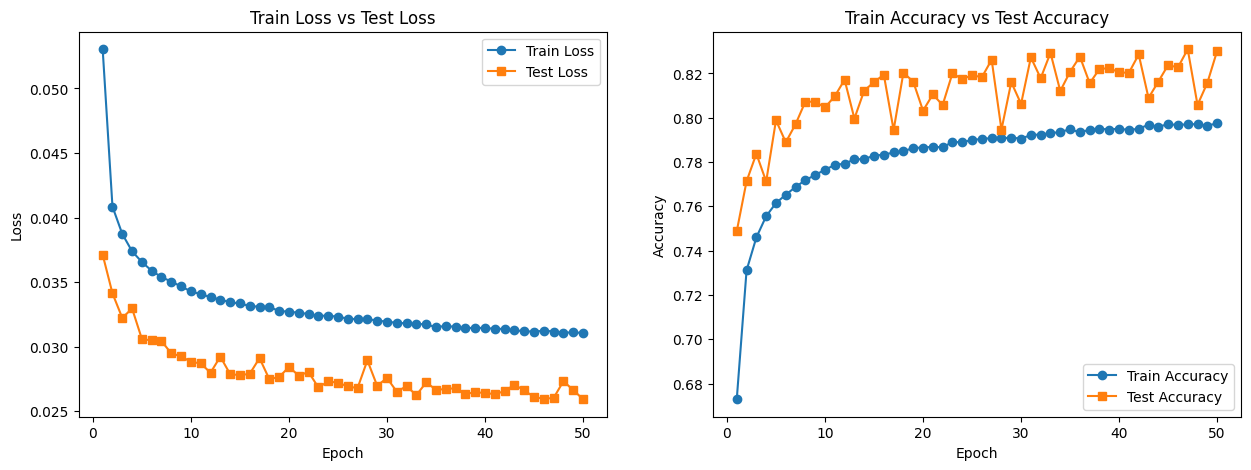

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

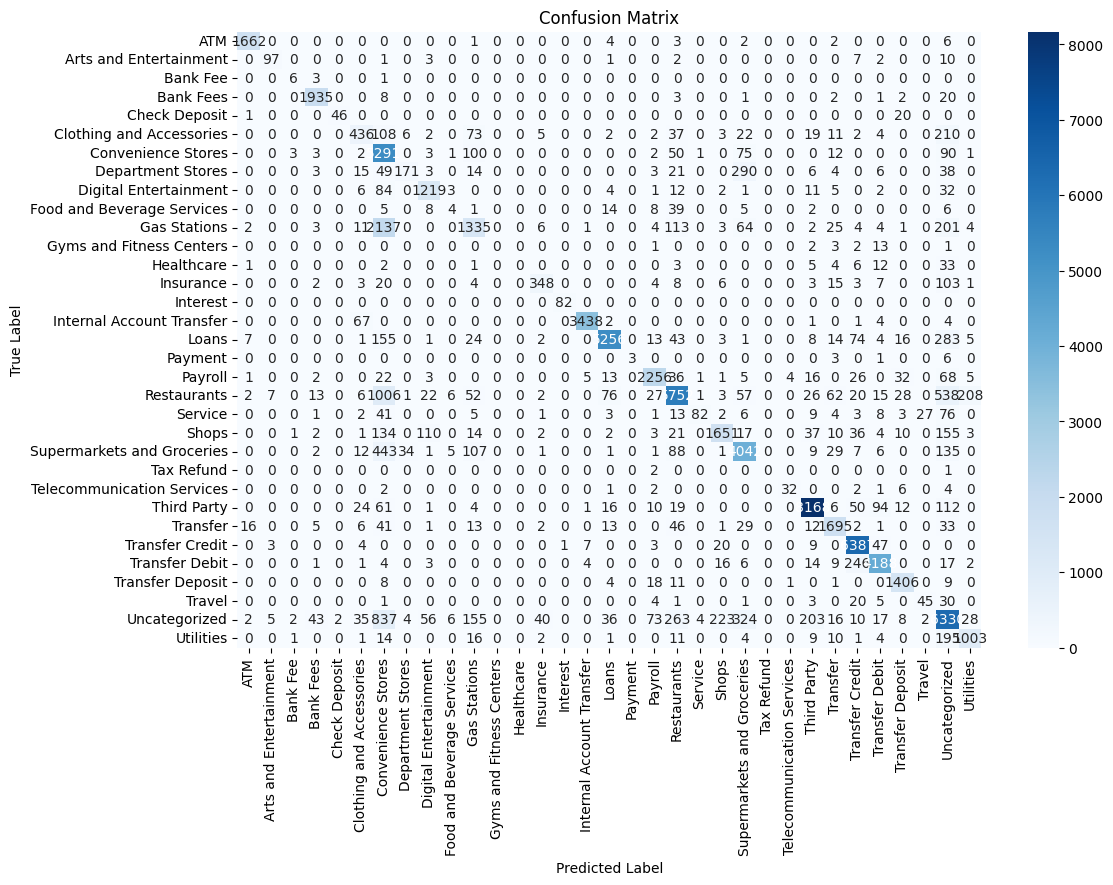

                            precision    recall  f1-score   support

                       ATM       0.98      0.99      0.99      1680
    Arts and Entertainment       0.87      0.79      0.83       123
                  Bank Fee       0.46      0.60      0.52        10
                 Bank Fees       0.96      0.98      0.97      1972
             Check Deposit       0.96      0.69      0.80        67
  Clothing and Accessories       0.69      0.46      0.55       942
        Convenience Stores       0.51      0.94      0.66      5634
         Department Stores       0.79      0.27      0.41       623
     Digital Entertainment       0.85      0.88      0.87      1382
Food and Beverage Services       0.16      0.04      0.07        92
              Gas Stations       0.70      0.34      0.46      3920
  Gyms and Fitness Centers       0.00      0.00      0.00        22
                Healthcare       0.00      0.00      0.00        67
                 Insurance       0.85      0.66

In [170]:
category_columns = [col for col in df.columns if col.startswith("category_")]
category_names = [col.replace("category_", "").replace("_", " ") for col in category_columns]  # Remove 'category_' prefix

model_name = "ANN_50e_1e-3lr_4l_classifier"

# Train and evaluate the model
train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, category_names, model_name, save_results=True, num_epochs=50, device=device)

#### Predict Categories for Random Test Instances

In [171]:
# Function to predict categories for test instances
def predict_random_test_samples(model, X_test_tensor, y_test_tensor, label_encoder, num_samples=5, device="cpu"):
    model.eval()  # Set model to evaluation mode
    X_test_tensor = X_test_tensor.to(device)
    
    with torch.no_grad():
        # Select random samples from the test set
        indices = np.random.choice(len(X_test_tensor), num_samples, replace=False)
        X_samples = X_test_tensor[indices]
        y_samples = y_test_tensor[indices]

        # Get model predictions
        outputs = model(X_samples)
        predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()  # Convert to category index
        true_classes = torch.argmax(y_samples, dim=1).cpu().numpy()  # Convert ground truth to category index

        # Convert indices to category labels
        predicted_labels = label_encoder.inverse_transform(predicted_classes)
        true_labels = label_encoder.inverse_transform(true_classes)

        # Print results
        print("\n===== Model Predictions vs. Ground Truth =====")
        for i in range(num_samples):
            print(f"Test Instance {i+1}:")
            print(f"  ➤ Predicted Category: {predicted_labels[i]}")
            print(f"  ➤ Ground Truth:      {true_labels[i]}")
            print("---------------------------------------------------")


In [172]:
# Extract category column names dynamically
category_columns = [col for col in df.columns if col.startswith("category_")]

# Create label encoder based on column order
label_encoder = LabelEncoder()
label_encoder.fit(category_columns) 

# Call the function to predict & compare results
predict_random_test_samples(model, X_test_tensor, y_test_tensor, label_encoder, num_samples=5, device=device)


===== Model Predictions vs. Ground Truth =====
Test Instance 1:
  ➤ Predicted Category: category_Uncategorized
  ➤ Ground Truth:      category_Uncategorized
---------------------------------------------------
Test Instance 2:
  ➤ Predicted Category: category_Uncategorized
  ➤ Ground Truth:      category_Uncategorized
---------------------------------------------------
Test Instance 3:
  ➤ Predicted Category: category_Arts and Entertainment
  ➤ Ground Truth:      category_Arts and Entertainment
---------------------------------------------------
Test Instance 4:
  ➤ Predicted Category: category_Loans
  ➤ Ground Truth:      category_Loans
---------------------------------------------------
Test Instance 5:
  ➤ Predicted Category: category_Uncategorized
  ➤ Ground Truth:      category_Uncategorized
---------------------------------------------------
